# Regional Sales Analysis

In this we will be running an introductory EDA on a regional sales database hosted in an Excel workbook with the following problem statements and business questions:

The problem statement is Sales teams often lack a clear, data-driven understanding of regional performance, making it difficult to identify growth opportunities and optimize resources.

This project aims to analyse and visualize regional sales data to uncover trends, evaluate profitability, and support strategic decision-making.

*   Inconsistent revenue and profit performance across U.S. regions
*   Lack of visibility into seasonal swings, top SKUs, and channel profitability
- Goal: Leverage 5 years of historical data to pinpoint growth levers and optimize strategy

# Import Excel Workbook and Create Data Frames



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

orders_df = pd.read_excel("/content/Regional Sales Dataset.xlsx", sheet_name="Sales Orders")
customers_df = pd.read_excel("/content/Regional Sales Dataset.xlsx", sheet_name="Customers")
regions_df = pd.read_excel("/content/Regional Sales Dataset.xlsx", sheet_name="Regions")
states_df = pd.read_excel("/content/Regional Sales Dataset.xlsx", sheet_name="State Regions")
products_df = pd.read_excel("/content/Regional Sales Dataset.xlsx", sheet_name="Products")
budget_df = pd.read_excel("/content/Regional Sales Dataset.xlsx", sheet_name="2017 Budgets")

Now we can run some basic data checks on our priarmy worksheet, orders_df

In [28]:
#Provide the 'shape' of the Orders data in its 'raw' format, which in this case is the number of rows and columns
orders_df.shape

(64104, 12)

In [29]:
#Counts the number of duplicate rows in the Orders dataframe
orders_df.duplicated().sum()

np.int64(0)

In [30]:
print(orders_df["OrderDate"].min()) #2014-01-01 00:00:00
print(orders_df["OrderDate"].max()) #2018-02-28 00:00:00

2014-01-01 00:00:00
2018-02-28 00:00:00


In [31]:
#Counts the number of entries in the 'Order Number' feature and returns the number of duplicates within the feature
dup_order_nums = orders_df['OrderNumber'].duplicated(keep=False)
orders_df[dup_order_nums].shape[0], orders_df['OrderNumber'].nunique()

(64104, 10684)

Here we find it has no duplicates, but there are multiple orders per 'order number', which will need to be considered when running analysis as there is not other unique identifier. We also fine here that there is cut-off date for our set in Feb 2018, which we may have to exclude from some analyses later

In [32]:
#Summary information about the Orders dataframe, including null values and datatypes
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   OrderNumber                64104 non-null  object        
 1   OrderDate                  64104 non-null  datetime64[ns]
 2   Customer Name Index        64104 non-null  int64         
 3   Channel                    64104 non-null  object        
 4   Currency Code              64104 non-null  object        
 5   Warehouse Code             64104 non-null  object        
 6   Delivery Region Index      64104 non-null  int64         
 7   Product Description Index  64104 non-null  int64         
 8   Order Quantity             64104 non-null  int64         
 9   Unit Price                 64104 non-null  float64       
 10  Line Total                 64104 non-null  float64       
 11  Total Unit Cost            64104 non-null  float64       
dtypes: d

In [33]:
#Shows the top 5 rows of data to get an idea of what it looks like
orders_df.head()

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,Line Total,Total Unit Cost
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,"2,499.10","14,994.60","1,824.34"
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,"2,351.70","25,868.70","1,269.92"
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.20,"5,869.20",684.74
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,"2,338.30","16,368.10","1,028.85"
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,"2,291.40","18,331.20","1,260.27"


# Merging Data from other Dataframes

In [34]:
# Merges Customer Names, Product Names, Delivery Region names and states and region information into Orders Dataframe based on shared keys to enrich base data
orders_df = orders_df.merge(customers_df[['Customer Index','Customer Names']], left_on='Customer Name Index', right_on='Customer Index', how='left').drop(columns=['Customer Index','Customer Name Index'])
orders_df = orders_df.merge(
    regions_df[['id','name','county','state_code','households','median_income','state']],
    left_on='Delivery Region Index',
    right_on='id',
    how='left').drop(columns=['id','Delivery Region Index'])
orders_df = orders_df.merge(
    products_df[['Index', 'Product Name']],
    left_on='Product Description Index',
    right_on='Index',
    how='left'
)

orders_df.drop(columns=['Product Description Index'], inplace=True)
orders_df = orders_df.merge(states_df[['Region','State']], left_on='state', right_on='State', how='left').drop(columns=['State'])

Here I also choose to create some derived fields which will be useful in future analysis

In [35]:
# Generates relevant derived fields for analysis based on current fields
orders_df['Profit'] = orders_df['Line Total'] - orders_df['Total Unit Cost']
orders_df['Margin'] = orders_df['Profit'] / orders_df['Line Total']
orders_df['Unit Cost'] = orders_df['Total Unit Cost'] / orders_df['Order Quantity']

orders_df['year'] = orders_df['OrderDate'].dt.year
orders_df['month'] = orders_df['OrderDate'].dt.month
orders_df['quarter'] = orders_df['OrderDate'].dt.to_period('Q')

# Formatting and Binning Data

In [36]:
# Formats all previous and current numerical features ot a numerical format
num_cols = ['Order Quantity','Unit Price','Line Total','Total Unit Cost','Profit','Unit Cost']
orders_df[num_cols] = orders_df[num_cols].replace({',':''}, regex=True).apply(pd.to_numeric, errors='coerce')

# Ensures all Order Date values are in the date-time format
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'], dayfirst=True, errors='coerce')

# Rounds float columns to 2 decimal places
cols_to_round = ['Profit', 'Margin', 'Unit Cost', 'Line Total', 'Total Unit Cost', 'Unit Price','median_income']
orders_df[cols_to_round] = orders_df[cols_to_round].round(2)



In [37]:
# Create bins for median income to make future analysis easier
orders_df['Median Income'] = pd.cut(
    orders_df['median_income'],
    bins=[0, 30000, 50000, 70000, 100000, 150000],
    labels=['≤30k', '30k–50k', '50k–70k', '70k–100k', '100k–150k'],
    include_lowest=True
)

# Do the same with number of houesholds
orders_df['Household Bin'] = pd.cut(
    orders_df['households'],
    bins=[0, 1000, 10000, 100000, 500000, 1000000, 2000000, 4000000],
    labels=['≤1k', '1k–10k', '10k–100k', '100k–500k', '500k–1M', '1M–2M', '2M+'],
    include_lowest=True
)


In [38]:
# Rename rows for legibility
orders_df.rename(columns={'name': 'Location'}, inplace=True)
orders_df.rename(columns={'Customer Names': 'Customer Name'}, inplace=True)
orders_df.rename(columns={'county': 'County'}, inplace=True)
orders_df.rename(columns={'state_code': 'State Shortened'}, inplace=True)
orders_df.rename(columns={'households': 'No. Households'}, inplace=True)
orders_df.rename(columns={'median_income': 'Median Income'}, inplace=True)
orders_df.rename(columns={'state': 'State'}, inplace=True)

Now we will re-run some of our basic checks to see the new version of the orders_df dataframe

In [39]:
# Shows new number of columns added and how the shape has changed
orders_df.shape

(64104, 27)

In [40]:
# Re-run of information to ensure there are no new issues because of the merged data
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderNumber      64104 non-null  object        
 1   OrderDate        64104 non-null  datetime64[ns]
 2   Channel          64104 non-null  object        
 3   Currency Code    64104 non-null  object        
 4   Warehouse Code   64104 non-null  object        
 5   Order Quantity   64104 non-null  int64         
 6   Unit Price       64104 non-null  float64       
 7   Line Total       64104 non-null  float64       
 8   Total Unit Cost  64104 non-null  float64       
 9   Customer Name    64104 non-null  object        
 10  Location         64104 non-null  object        
 11  County           64104 non-null  object        
 12  State Shortened  64104 non-null  object        
 13  No. Households   64104 non-null  int64         
 14  Median Income    64104 non-null  int64

In [41]:
# Re-run of head to see how new dataframe looks
orders_df.head()

,OrderNumber,OrderDate,Channel,Currency Code,Warehouse Code,Order Quantity,Unit Price,Line Total,Total Unit Cost,Customer Name,...,Product Name,Region,Profit,Margin,Unit Cost,year,month,quarter,Median Income,Household Bin
0,SO - 000225,2014-01-01,Wholesale,USD,AXW291,6,"2,499.10","14,994.60","1,824.34",Rhynoodle Ltd,...,Product 27,South,"13,170.26",0.88,304.06,2014,1,2014Q1,30k–50k,10k–100k
1,SO - 0003378,2014-01-01,Distributor,USD,AXW291,11,"2,351.70","25,868.70","1,269.92",Thoughtmix Ltd,...,Product 20,Midwest,"24,598.78",0.95,115.45,2014,1,2014Q1,50k–70k,10k–100k
2,SO - 0005126,2014-01-01,Wholesale,USD,AXW291,6,978.20,"5,869.20",684.74,Amerisourc Corp,...,Product 26,West,"5,184.46",0.88,114.12,2014,1,2014Q1,100k–150k,10k–100k
3,SO - 0005614,2014-01-01,Export,USD,AXW291,7,"2,338.30","16,368.10","1,028.85",Colgate-Pa Group,...,Product 7,Midwest,"15,339.25",0.94,146.98,2014,1,2014Q1,30k–50k,10k–100k
4,SO - 0005781,2014-01-01,Wholesale,USD,AXW291,8,"2,291.40","18,331.20","1,260.27",Deseret Group,...,Product 8,Northeast,"17,070.93",0.93,157.53,2014,1,2014Q1,50k–70k,10k–100k


In [42]:
# Basic statistical information for all numerical columns
orders_df.describe().T

,count,mean,min,25%,50%,75%,max,std
OrderDate,64104,2016-01-29 01:28:20.935979008,2014-01-01 00:00:00,2015-01-13 00:00:00,2016-01-27 00:00:00,2017-02-13 00:00:00,2018-02-28 00:00:00,NaN
Order Quantity,"64,104.00",8.44,5.00,6.00,8.00,10.00,12.00,2.28
Unit Price,"64,104.00","2,284.38",167.50,"1,031.80","1,855.90","3,606.28","6,566.00","1,663.60"
Line Total,"64,104.00","19,280.68",837.50,"8,019.90","14,023.10","27,416.40","78,711.60","15,429.60"
Total Unit Cost,"64,104.00","1,432.08",68.68,606.22,"1,084.50","2,046.93","5,498.56","1,107.71"
No. Households,"64,104.00","57,025.20",0.00,"22,639.00","29,518.00","45,409.00","3,113,535.00","143,773.29"
Median Income,"64,104.00","59,396.94",0.00,"43,163.00","53,587.50","71,897.00","149,837.00","21,556.19"
Index,"64,104.00",14.91,1.00,6.00,15.00,24.00,30.00,8.79
Profit,"64,104.00","17,848.60",695.12,"7,326.45","12,967.45","25,144.60","75,801.52","14,493.98"
Margin,"64,104.00",0.92,0.83,0.90,0.93,0.94,0.97,0.03


With that done, we can now move forward onto some analyis and further insights

## Regional Analysis

Here we will look to get an idea of the total profits per year of each region to identify the highest and lowest profit regions

/tmp/ipython-input-3475016284.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${y:,.2f}M' for y in yticks])


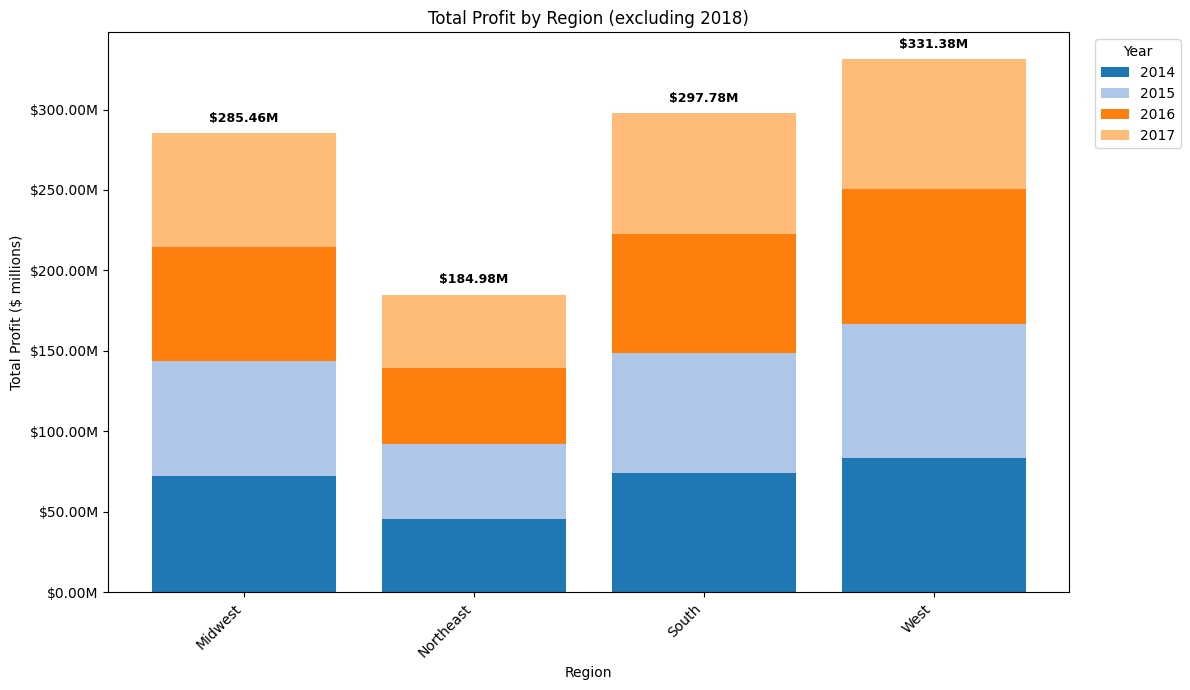

In [43]:
# Use your orders_df as source
df = orders_df.copy()

# Exclude 2018
df = df[df['year'] != 2018]

# Aggregate total Profit by Region and Year
profit_by_region_year = (
    df
    .groupby(['Region', 'year'], as_index=False)
    .agg(TotalProfit=('Profit', 'sum'))
)

# Pivot so rows are Region and columns are Year, fill missing with 0 and sort years
profit_pivot = profit_by_region_year.pivot(index='Region', columns='year', values='TotalProfit').fillna(0)
profit_pivot = profit_pivot.reindex(sorted(profit_pivot.columns), axis=1)

# Convert to millions for plotting
profit_pivot_m = profit_pivot / 1_000_000

# Plot stacked bar chart (years stacked)
fig, ax = plt.subplots(figsize=(12, 7))
regions = profit_pivot_m.index.tolist()
years = profit_pivot_m.columns.tolist()
bottom = np.zeros(len(regions))

cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

for i, year in enumerate(years):
    vals = profit_pivot_m[year].values
    ax.bar(regions, vals, bottom=bottom, label=str(year), color=colors[i])
    bottom = bottom + vals

# Labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Total Profit ($ millions)')
ax.set_title('Total Profit by Region (excluding 2018)')

# Format y-axis ticks as $X.XXM
yticks = ax.get_yticks()
ax.set_yticklabels([f'${y:,.2f}M' for y in yticks])

# Annotate total profit per region on top of each stacked bar
totals_m = profit_pivot_m.sum(axis=1).values
for xi, total in enumerate(totals_m):
    ax.annotate(f'${total:,.2f}M',
                xy=(xi, total),
                xytext=(0, 6),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, fontweight='semibold')

# Legend and layout
ax.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [44]:
# Filter using orders_df
mask = orders_df['year'] != 2018

# Pivot: Region x Year table of total profit (excluding 2018)
by_region_year = orders_df.loc[mask].groupby(['Region', 'year'])['Profit'].sum().unstack(fill_value=0).sort_index()

# Per-region summary stats
region_stats = pd.DataFrame({
    'Mean': by_region_year.mean(axis=1),
    'Std':  by_region_year.std(axis=1, ddof=0)
})
region_stats['CV'] = region_stats['Std'] / region_stats['Mean'].replace({0: np.nan})

pd.options.display.float_format = '{:,.2f}'.format
print("Total profit by region and year (excluding 2018):")
print(by_region_year)
print("\nPer-region statistics (excluding 2018):")
print(region_stats.reset_index())



Total profit by region and year (excluding 2018):
year               2014          2015          2016          2017
Region                                                           
Midwest   72,148,200.15 71,747,698.83 70,727,497.88 70,831,678.40
Northeast 45,351,543.31 46,731,471.75 47,568,657.83 45,328,310.67
South     74,416,540.15 74,547,455.44 73,902,648.25 74,912,142.31
West      83,526,910.73 83,292,254.98 83,669,643.71 80,894,779.60

Per-region statistics (excluding 2018):
      Region          Mean          Std   CV
0    Midwest 71,363,768.81   602,224.15 0.01
1  Northeast 46,244,995.89   952,274.78 0.02
2      South 74,444,696.54   361,826.64 0.00
3       West 82,845,897.25 1,134,507.92 0.01


Based on these, we can see that the West and South region make up the highest proporiton of profits, while the Northeast comes up as the lowest by far.

Depending on the intent of the company, you could either look to run experimental targetted campaigns in the Northeast to see if this would increase their overall profit (as they may be an underserved region) or you could look to capitalise on already higher profit regions such as the West to increase the already higher proportion.

## Seasonaility

Next, I would like to get an overview of some seasonality based on profits. In this case I have chosen to exclude 2018 as it will otherwise act as an outlier and make any insights obscured.

/tmp/ipython-input-2445464143.py:15: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ts_quarterly = df.set_index('OrderDate')['Profit'].resample('Q').sum().sort_index()


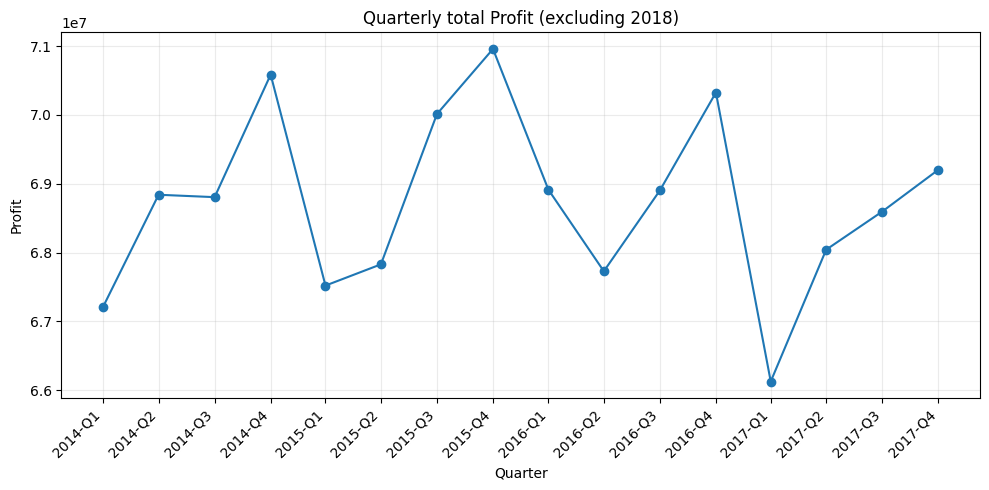

In [45]:
from matplotlib.dates import DateFormatter

# Use your existing DataFrame named orders_df
df = orders_df.copy()

# Clean and types
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')
df = df.dropna(subset=['OrderDate'])
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce').fillna(0)

# Exclude any rows from 2018
df = df[df['OrderDate'].dt.year != 2018]

# Quarterly totals (quarter-end timestamps)
ts_quarterly = df.set_index('OrderDate')['Profit'].resample('Q').sum().sort_index()

# Simple line plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts_quarterly.index, ts_quarterly.values, marker='o', linestyle='-', color='C0')
ax.set_title('Quarterly total Profit (excluding 2018)')
ax.set_xlabel('Quarter')
ax.set_ylabel('Profit')
ax.grid(alpha=0.25)

# Format x-axis tick labels as Year-Quarter
xticks = ts_quarterly.index
ax.set_xticks(xticks)
ax.set_xticklabels([d.to_period('Q').strftime('%Y-Q%q').replace('%q', str((d.month-1)//3+1))
                    for d in xticks], rotation=45, ha='right')

plt.tight_layout()
plt.show()

We can see here that are universally large dips in profits around the first quarter of the year, while there are majour uplifts in the last quarters. Depending on the nature of the product, this could suggest a natural seasonality (like holiday items) or otherwise a further analysis could be done to explore why the first quarter is a regular dipping point.

If we assume that this is not a naturally seasonal item, we could consider running experimental campaigns in these lower periods to see what affect they may have on first quarter performance.

# Product Analysis

Next, I would like to perform some analysis on our products, to idetify best and worst performing units by profit along with order numbers.

To go along with this, I would like to run a cast study of the year 2017 (as this is only year we are provided clear budgets for) and see how our profits and costs per unit have compared to those budgets.

/tmp/ipython-input-2873376425.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([fmt_money.format(y) for y in yticks])


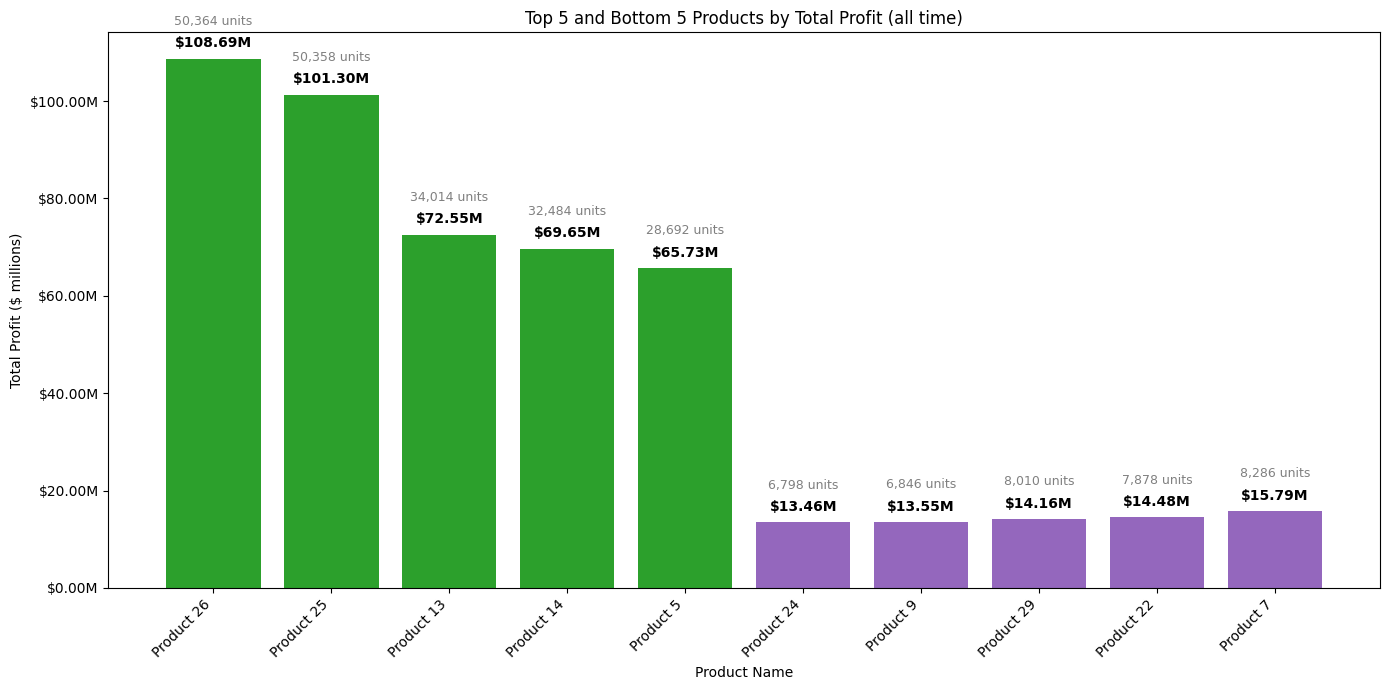

In [46]:
# Aggregate per product: total profit and total units sold
prod_stats = (
    orders_df
    .groupby('Product Name', as_index=False)
    .agg(TotalProfit=('Profit', 'sum'),
         TotalUnits=('Order Quantity', 'sum'))
    .sort_values('TotalProfit', ascending=False)
    .reset_index(drop=True)
)

# Select top 5 and bottom 5, keep top block first then bottom block
top5 = prod_stats.head(5).copy()
bottom5 = prod_stats.tail(5).copy()
# For visual clarity, order bottom5 ascending by profit (so smallest is left)
bottom5 = bottom5.sort_values('TotalProfit', ascending=True)
plot_df = pd.concat([top5, bottom5], ignore_index=True)

# Prepare plotting values (millions) and labels
plot_df['ProfitM'] = plot_df['TotalProfit'] / 1_000_000
fmt_money = '${:,.2f}M'

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(plot_df))
bars = ax.bar(x, plot_df['ProfitM'], color=['C2']*len(top5) + ['C4']*len(bottom5))

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(plot_df['Product Name'], rotation=45, ha='right')
ax.set_xlabel('Product Name')
ax.set_ylabel('Total Profit ($ millions)')
ax.set_title('Top 5 and Bottom 5 Products by Total Profit (all time)')

# Format y-axis ticks as $X.XXM (without mtick)
yticks = ax.get_yticks()
ax.set_yticklabels([fmt_money.format(y) for y in yticks])

# Annotate each bar: profit on first line, units on second line
for bar, profit_m, units in zip(bars, plot_df['ProfitM'], plot_df['TotalUnits']):
    xloc = bar.get_x() + bar.get_width() / 2
    yloc = bar.get_height()
    ax.annotate(fmt_money.format(profit_m),
                xy=(xloc, yloc),
                xytext=(0, 6),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10, fontweight='semibold')
    ax.annotate(f'{int(units):,} units',
                xy=(xloc, yloc),
                xytext=(0, 22),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, color='gray')

plt.tight_layout()
plt.show()




From this we can get a clear picture of our 5 best and worst performing products by profit. Product 26 and 25 are our top performers both in units sold and total profit (which makes sense given they are each generally around 16,000 units sold higher than Product 13).

The worst performers were Products 24 and Product 9 and were also the lowest selling units overall.

Given this information, you could consider wherther you still need to stock the lowest profit products or if you could cut their budgets. You may aso want to put more resource behidn the top 5, though be aware this could make you a bit top-heavy if a competitor came out with a similaur product to them at potentially a lower price.

/tmp/ipython-input-2273203739.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${y:,.2f}M' for y in yticks])


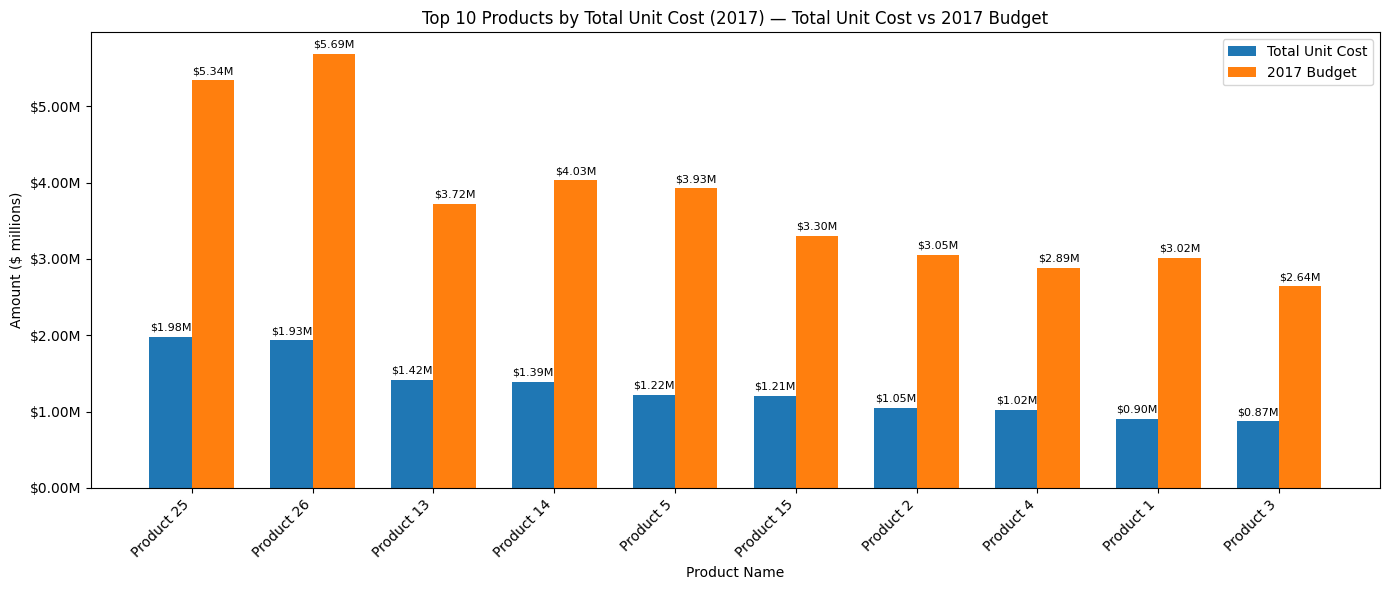

In [47]:
# Filter orders_df for 2017
orders_2017 = orders_df[orders_df['OrderDate'].dt.year == 2017]

# Aggregate total unit cost per product from orders_2017
cost_df = orders_2017.groupby('Product Name', as_index=False).agg({'Total Unit Cost': 'sum'})

# Merge cost and budget data from budget_df
summary_df = cost_df.merge(
    budget_df[['Product Name', '2017 Budgets']],
    on='Product Name',
    how='left'
)

# Select top 10 products by Total Unit Cost
summary_top10 = summary_df.sort_values('Total Unit Cost', ascending=False).head(10).reset_index(drop=True)

# Convert amounts to millions (keeps originals unchanged)
summary_top10['Total Unit Cost (M)'] = summary_top10['Total Unit Cost'] / 1_000_000
summary_top10['2017 Budgets (M)'] = summary_top10['2017 Budgets'] / 1_000_000

# Plot setup
x = np.arange(len(summary_top10['Product Name']))
width = 0.35
fig, ax = plt.subplots(figsize=(14, 6))

bars1 = ax.bar(x - width/2, summary_top10['Total Unit Cost (M)'], width, label='Total Unit Cost')
bars2 = ax.bar(x + width/2, summary_top10['2017 Budgets (M)'], width, label='2017 Budget')

# Axis labels and title
ax.set_xlabel('Product Name')
ax.set_ylabel('Amount ($ millions)')
ax.set_title('Top 10 Products by Total Unit Cost (2017) — Total Unit Cost vs 2017 Budget')
ax.set_xticks(x)
ax.set_xticklabels(summary_top10['Product Name'], rotation=45, ha='right')
ax.legend()

# Manually format y-tick labels as $X.XXM
yticks = ax.get_yticks()
ax.set_yticklabels([f'${y:,.2f}M' for y in yticks])

# Add data labels formatted as $X.XXM using the million values
def add_labels(bars, values_m):
    for bar, val in zip(bars, values_m):
        ax.annotate(f'${val:,.2f}M',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1, summary_top10['Total Unit Cost (M)'])
add_labels(bars2, summary_top10['2017 Budgets (M)'])

plt.tight_layout()
plt.show()







This chart shows that all products cost below their given budgets to produce and shows a weak correlation between the budget offered and the amount of units solve. It does show that the budgets for 25 and 26 are also quite a lot higher than the other budgets.

You could potentially experiment on reallocating some of the budget from 25 and 26 to other mid performing products to see if any rise in their sales and profits counteracts any potential loss of 25 and 26.

/tmp/ipython-input-3479320620.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${y:,.2f}M' for y in yticks])


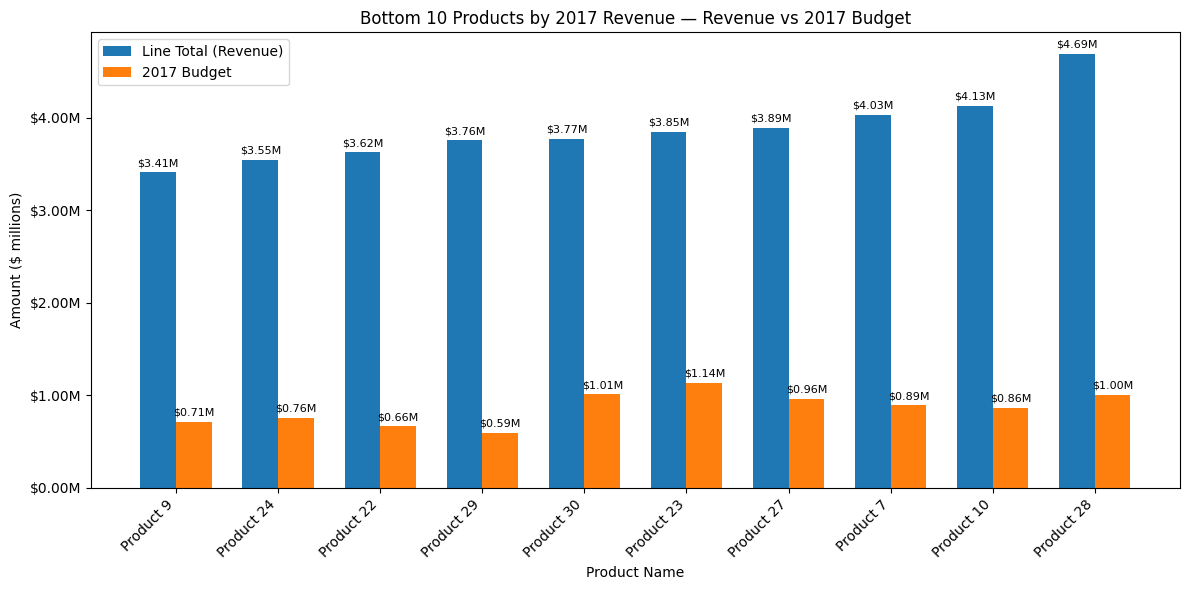

In [48]:
# Filter orders_df for 2017
orders_2017 = orders_df[orders_df['OrderDate'].dt.year == 2017]

# Aggregate line total (revenue) per product for 2017
revenue_df = orders_2017.groupby('Product Name', as_index=False).agg({'Line Total': 'sum'})

# Merge revenue with budget_df
summary_df = revenue_df.merge(
    budget_df[['Product Name', '2017 Budgets']],
    on='Product Name',
    how='left'
)

# Select bottom 10 products by revenue (lowest Line Total)
summary_bottom10 = summary_df.sort_values('Line Total', ascending=True).head(10).reset_index(drop=True)

# Convert to millions for plotting (keep originals unchanged)
summary_bottom10['Line Total (M)'] = summary_bottom10['Line Total'] / 1_000_000
summary_bottom10['2017 Budgets (M)'] = summary_bottom10['2017 Budgets'] / 1_000_000

# Plot setup
x = np.arange(len(summary_bottom10['Product Name']))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))

bars_rev = ax.bar(x - width/2, summary_bottom10['Line Total (M)'], width, label='Line Total (Revenue)')
bars_bud = ax.bar(x + width/2, summary_bottom10['2017 Budgets (M)'], width, label='2017 Budget')

# Axis labels and title
ax.set_xlabel('Product Name')
ax.set_ylabel('Amount ($ millions)')
ax.set_title('Bottom 10 Products by 2017 Revenue — Revenue vs 2017 Budget')
ax.set_xticks(x)
ax.set_xticklabels(summary_bottom10['Product Name'], rotation=45, ha='right')
ax.legend()

# Manually format y-tick labels as $X.XXM
yticks = ax.get_yticks()
ax.set_yticklabels([f'${y:,.2f}M' for y in yticks])

# Add data labels formatted as $X.XXM using the million values
def add_labels(bars, values_m):
    for bar, val in zip(bars, values_m):
        ax.annotate(f'${val:,.2f}M',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars_rev, summary_bottom10['Line Total (M)'])
add_labels(bars_bud, summary_bottom10['2017 Budgets (M)'])

plt.tight_layout()
plt.show()


Here we can see that the lowest revenue products also have some of the lowest budgets, which could mean that if we reallocate some funds from the higher budgets to here that they may increase, though we would have to double check their margins before making that choice.

# Customer Analysis

Here we are going to look at the profits of our top and bottom 5 customers to see if we can get an idea of our concerntration risk.

/tmp/ipython-input-2092636611.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([fmt_money.format(y) for y in yticks])


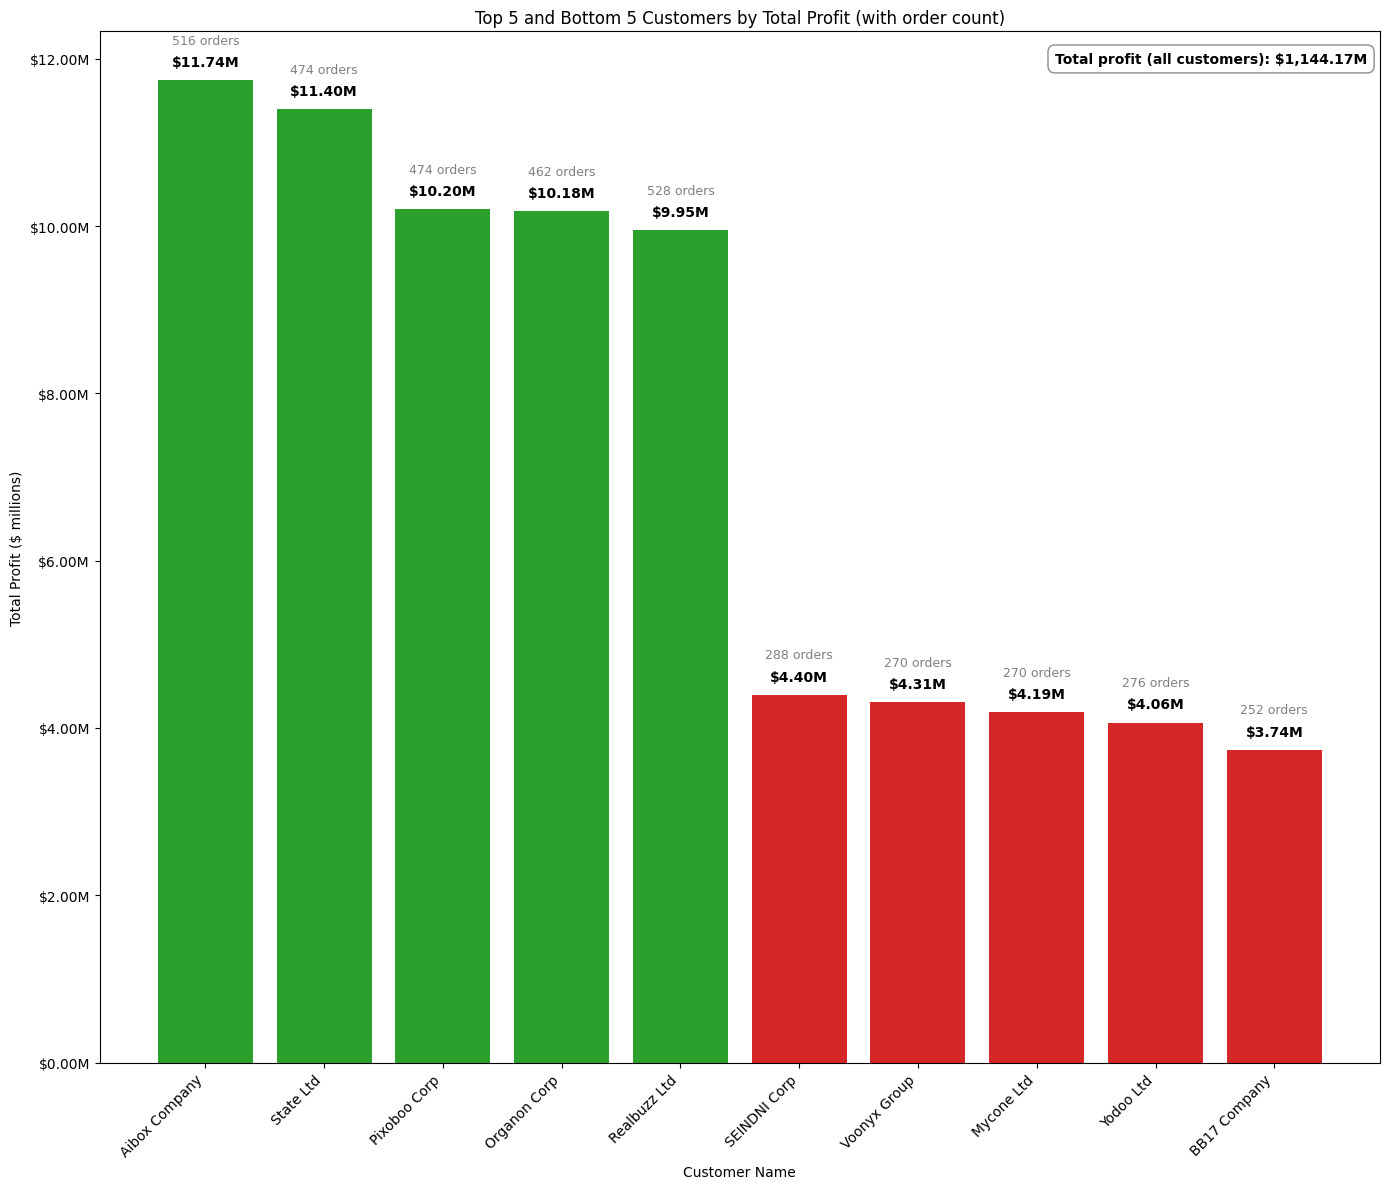

In [49]:
# Group and compute total profit + order count (use 'Order Number' if available)
if 'Order Number' in orders_df.columns:
    customer_stats = (
        orders_df
        .groupby('Customer Name', as_index=False)
        .agg(TotalProfit=('Profit', 'sum'),
             OrderCount=('Order Number', 'nunique'))
        .sort_values('TotalProfit', ascending=False)
        .reset_index(drop=True)
    )
else:
    customer_stats = (
        orders_df
        .groupby('Customer Name', as_index=False)
        .agg(TotalProfit=('Profit', 'sum'),
             OrderCount=('Profit', 'count'))  # fallback: count rows
        .sort_values('TotalProfit', ascending=False)
        .reset_index(drop=True)
    )

# Compute overall total profit for annotation
total_profit_all = customer_stats['TotalProfit'].sum()
total_profit_all_m = total_profit_all / 1_000_000
total_profit_label = f'Total profit (all customers): ${total_profit_all_m:,.2f}M'

# Select top 5 and bottom 5
top5 = customer_stats.head(5).copy()

# For bottom 5: take the bottom 5 by profit, then sort them so the smallest profit is last
bottom5 = customer_stats.tail(5).copy()
# reorder bottom5 so that the largest among the bottom5 appears first and the smallest last
bottom5 = bottom5.sort_values('TotalProfit', ascending=False).reset_index(drop=True)

# Concatenate for plotting (top5 first, bottom5 next with very-bottom last)
plot_df = pd.concat([top5, bottom5], ignore_index=True)

# Prepare plotting values in millions and label format
plot_df['ProfitM'] = plot_df['TotalProfit'] / 1_000_000
fmt_money = '${:,.2f}M'

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
x = np.arange(len(plot_df))
# color top5 differently from bottom5
colors = ['C2'] * len(top5) + ['C3'] * len(bottom5)
bars = ax.bar(x, plot_df['ProfitM'], color=colors)

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(plot_df['Customer Name'], rotation=45, ha='right')
ax.set_xlabel('Customer Name')
ax.set_ylabel('Total Profit ($ millions)')
ax.set_title('Top 5 and Bottom 5 Customers by Total Profit (with order count)')

# Format y-axis ticks as $X.XXM
yticks = ax.get_yticks()
ax.set_yticklabels([fmt_money.format(y) for y in yticks])

# Annotate each bar with profit and percentage of total (two-line label)
for bar, profit_m, orders in zip(bars, plot_df['ProfitM'], plot_df['OrderCount']):
    xloc = bar.get_x() + bar.get_width() / 2
    yloc = bar.get_height()
    ax.annotate(fmt_money.format(profit_m),
                xy=(xloc, yloc),
                xytext=(0, 8),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10, fontweight='semibold')
    ax.annotate(f'{int(orders):,} orders',
                xy=(xloc, yloc),
                xytext=(0, 24),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, color='gray')

# Add total profit text box in the top-right corner of the axes
ax.text(0.99, 0.98, total_profit_label,
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=10, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()



This chart shows that we have some very high value customers who are carrying our total profits, which suggests a heavy dependance on these accounts. They also have the highest order counts, which means they buy a lot and frequently.

The bottom 5 meanwhile still contribute meaningfully to the total and should not be disregarded.

Given the risk of losing any one of these top 5 and their impact on the overall profit, it would be a good move to mitigate risk by ensuring their custom with assigned account owners or similar. You could also look into cross-sell opportunities for mid level companies to spread risk.

# Marketing Channel Analysis

Finally we will have a look at the marketing channel performance

/tmp/ipython-input-2839192483.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${y:,.1f}M' for y in yticks])


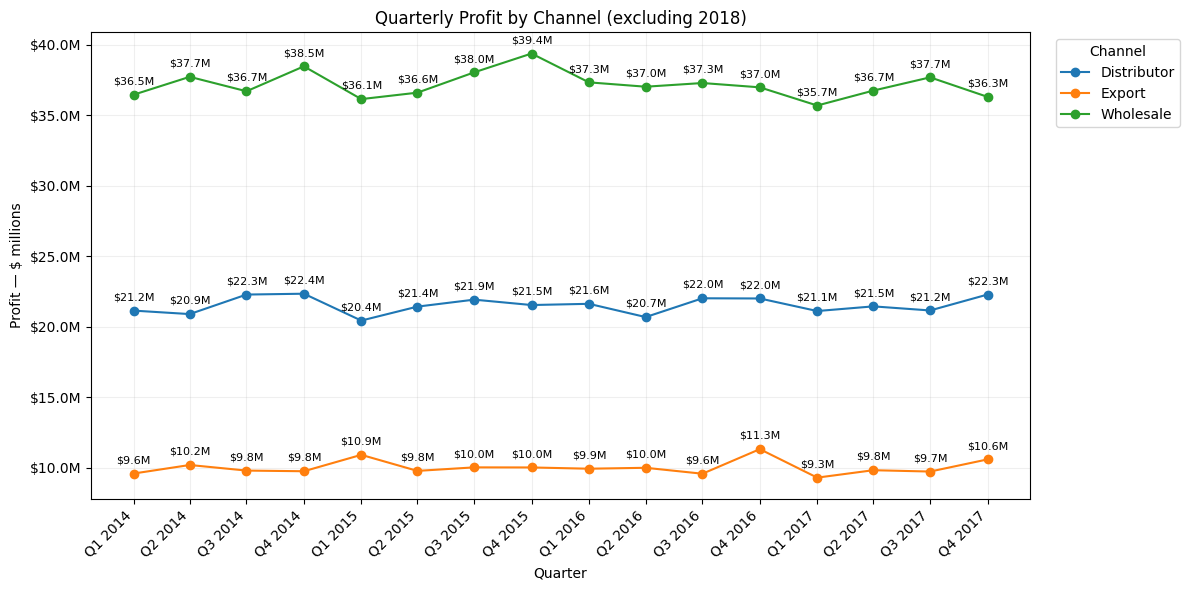

In [50]:
def quarter_to_timestamp(q):
    q = str(q).replace('-', '')
    return pd.Period(q, freq='Q').to_timestamp()

# Exclude 2018
orders_df['QuarterTS'] = orders_df['quarter'].astype(str).apply(quarter_to_timestamp)
df_q = orders_df[ orders_df['QuarterTS'].dt.year != 2018 ]

agg = df_q.groupby(['QuarterTS','Channel'], as_index=False).agg({'Profit':'sum'})
pivot = agg.pivot(index='QuarterTS', columns='Channel', values='Profit').fillna(0).sort_index()
pivot_m = pivot / 1_000_000  # values in millions

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for channel in pivot_m.columns:
    y = pivot_m[channel].values
    x = pivot_m.index
    ax.plot(x, y, marker='o', label=channel)
    # add data labels for each point (one decimal place)
    for xi, yi in zip(x, y):
        ax.annotate(f'${yi:,.1f}M',
                    xy=(xi, yi),
                    xytext=(0, 6),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Quarter')
ax.set_ylabel('Profit — $ millions')
ax.set_title('Quarterly Profit by Channel (excluding 2018)')
ax.grid(alpha=0.2)

# X tick labels as Q<quarter> YYYY
xticks = pivot_m.index
ax.set_xticks(xticks)
ax.set_xticklabels([f"Q{pd.Period(ts, freq='Q').quarter} {pd.Period(ts, freq='Q').year}" for ts in xticks],
                   rotation=45, ha='right')

# Format y-ticks manually as $X.XM
yticks = ax.get_yticks()
ax.set_yticklabels([f'${y:,.1f}M' for y in yticks])

ax.legend(title='Channel', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



From here we can see that Wholesale is the overall dominant channel and has the largest profit contribution. Distributor sits in the middle and is relatively stable quarter on quarter while export is the lowest but is less volatile than wholesale.

Targeted investment in Distributor and Export channels could help spread risk and increase general profit, while also performing some measures to protect wholesale like confirming health of contracts and their operational effciency.

# Conclusion

Overall, the following growth levers and strategic opimisations could be suggested:

Protect currently high performing customers and marketing channels

by auditing their contract health and assigning account owners.

Look into diversifying risk across other mid-tier accounts to increase profit and mititgate top-heavy risks to profile

Revisit product budgets, raising budgets for underfunded products to realise greater revenues and run controlled experiments shifting a small portion of promotional/budget from 25/26 to mid performers and measure net lift

Run experiments in Q1 (promos, bundles, targeted ads) and measure incremental orders and profit

Test Northeast: run targeted, low-cost demand tests to assess addressable upside in under‑penetrated regions